## Imports

In [2]:
import os
import glob
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.models import load_model
from keras.callbacks import CSVLogger
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Constants

In [3]:
VERSION = "3"
TRAINING_SET_SRC_PATH = "../resources/sign_mnist_train.csv"
TEST_SET_SRC_PATH = "../resources/sign_mnist_test.csv"
TRAINED_MODEL_PATH = f"../resources/trained_model_{VERSION}.h5"
TRAINING_LOG_PATH = f"../resources/training_{VERSION}.log"
IMAGE_A_PATH = "../resources/A.jpeg"
ASL_TRAIN_SET_PATH = "../resources/asl_data_set/asl_alphabet_train/asl_alphabet_train"

In [4]:
classes = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labels = []
features = []

for c in classes:
    file_list = glob.glob(f"{ASL_TRAIN_SET_PATH}/{c}/*.jpg")
    for item in file_list:
        features.append(item)
        labels.append(c)
print(f"Amount of features: {len(features)} ; Amount of labels: {len(labels)}")

Amount of features: 78000 ; Amount of labels: 78000


In [10]:
train_values = []
train_labels = []
validation_values = []
validation_labels = []

for i in features:
    img = cv.imread(i,cv.IMREAD_GRAYSCALE)
    train_values.append(img)
    train_values[-1] = np.reshape(train_values[-1],[200,200,1])

for i in labels:
    train_labels.append(i)

train_values,validation_values,train_labels,validation_labels = train_test_split(train_values, train_labels,test_size=0.3)
print("Train data : ",len(train_values),len(train_labels))
print("Validation data : ",len(validation_values),len(validation_labels))

Train data :  54600 54600
Validation data :  23400 23400


<AxesSubplot:ylabel='count'>

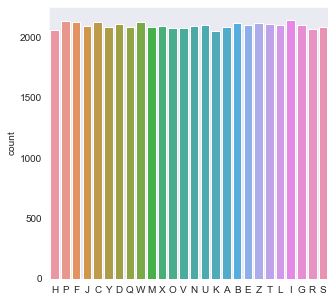

In [11]:
plt.figure(figsize = (5, 5))
sns.set_style("dark")
sns.countplot(x=train_labels)

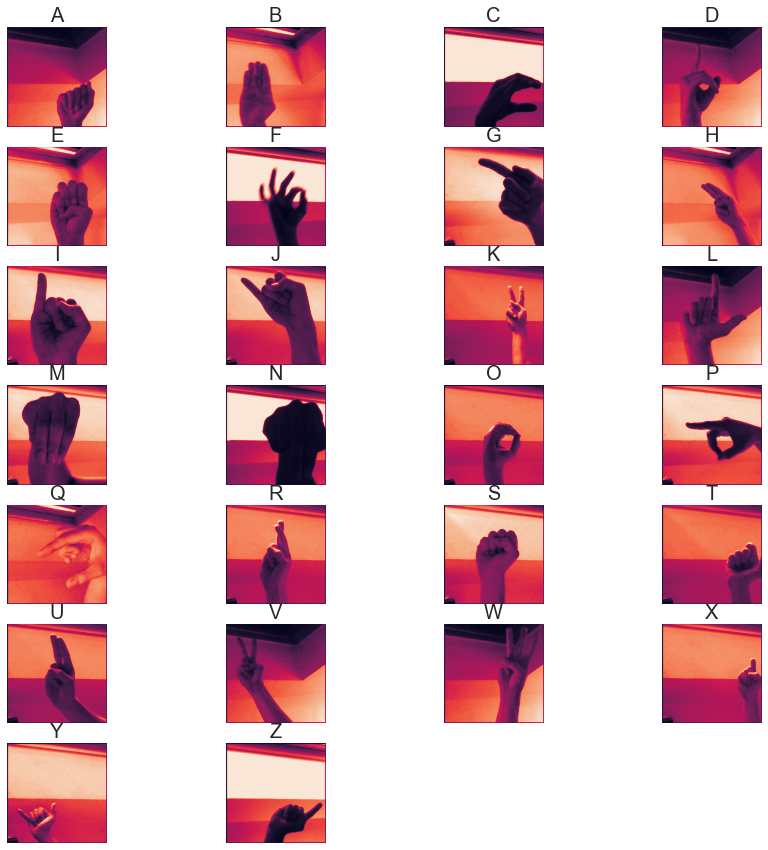

In [12]:
un,count = np.unique(train_labels,return_counts=True)
j=1
plt.figure(figsize=(15,15))
for i in un:
    plt.subplot(7,4,j)
    plt.imshow(train_values[np.where(train_labels == np.array(i))[0][0]])
    plt.axis('off')
    plt.title(str(classes[j-1]),fontdict=dict({'fontsize' : 20}))
    j=j+1

In [13]:
label_binarizer = LabelBinarizer()
train_labels = label_binarizer.fit_transform(train_labels)
validation_labels = label_binarizer.fit_transform(validation_labels)

In [14]:
train_values = np.array(train_values)
validation_values = np.array(validation_values)
train_values = train_values.reshape(-1,200,200,1)
test_values = validation_values.reshape(-1,200,200,1)

## Data normalization 
CNN are known to converges faster and better on normalized data <br>
at scale of [0..1] (than on [0..255]).

In [15]:
train_values = train_values / 255
test_values = test_values / 255

## Data augmentation using keras.

1. Accepting a batch of images used for training.
2. Taking this batch and applying a series of random transformations to each image in the batch (including random rotation, resizing, shearing, etc.).
3. **Replacing the original batch** with the new, randomly transformed batch.
4. Training the CNN on this randomly transformed batch (i.e., the original data itself is not used for training).

*data augmentation illustration*<br>
<img src="https://www.pyimagesearch.com/wp-content/uploads/2019/07/keras_data_augmentation_header.png" alt="data-augmentation" width="250"/>

In [16]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(train_values)

## Creating the CONVOLUTIONAL NEURAL NETWORKS

In [35]:
if os.path.exists(TRAINED_MODEL_PATH):
    print("Found a backup trained model file, will load now...")
    model = load_model(TRAINED_MODEL_PATH)
    print("Loaded model file:")
else: 
    model = Sequential()
    model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (200,200,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Flatten())
    model.add(Dense(units = 512 , activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(units = 26 , activation = 'softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    print("Couldn't find an existing model file. Created a new one:")
model.summary()

Couldn't find an existing model file. Created a new one:
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 200, 200, 75)      750       
_________________________________________________________________
batch_normalization_15 (Batc (None, 200, 200, 75)      300       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 100, 100, 75)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 100, 100, 50)      33800     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100, 100, 50)      0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 100, 100, 50)      200       
_______________________________________________________________

## Model Training

In [32]:
# this will be passed as a callback to the model.fit action, in order to Reduce learning rate when a metric has stopped improving.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [37]:
if not os.path.exists(TRAINING_LOG_PATH):
    print("Didn't find a training log history, will re-train the model")    
    csv_logger = CSVLogger(TRAINING_LOG_PATH, separator=',', append=False)
    history = model.fit(datagen.flow(train_values, train_labels, batch_size = 20) ,epochs = 20 , validation_data = (validation_values, validation_labels) , callbacks = [learning_rate_reduction ,csv_logger])
    model.save(TRAINED_MODEL_PATH)
    history = history.history
else:
    print("Found a trained model file, will load the training log history")
    history = pd.read_csv(TRAINING_LOG_PATH, sep=',', engine='python')


Didn't find a training log history, will re-train the model
Epoch 1/20
  26/2730 [..............................] - ETA: 51:28 - loss: 9.5223 - accuracy: 0.0919

## Evaluation

In [ ]:
print("Accuracy of the model is - " , model.evaluate(test_values, test_labels)[1]*100 , "%")

225/225 [==============================] - 5s 21ms/step - loss: 0.0732 - accuracy: 0.9824
Accuracy of the model is -  98.24316501617432 %


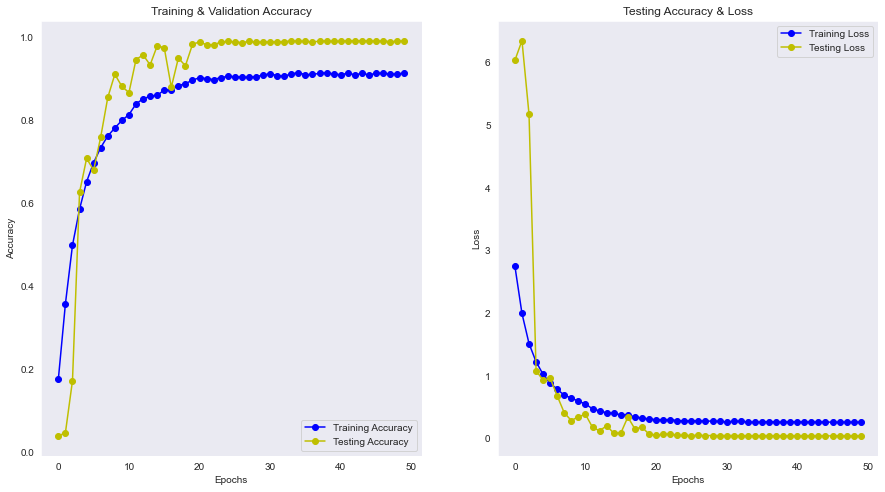

In [ ]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history['accuracy']
train_loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']
fig.set_size_inches(15,8)

ax[0].plot(epochs , train_acc , 'bo-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'b-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

#### Classification report

In [ ]:
predictions = np.argmax(model.predict(test_values), axis=-1)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(test_df_src["label"], predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      0.97      0.98       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      0.83      0.91       245
     Class 4       1.00      0.93      0.97       498
     Class 5       1.00      1.00      1.00       247
     Class 6       0.99      0.98      0.99       348
     Class 7       0.98      1.00      0.99       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       0.85      1.00      0.92       209
    Class 12       0.92      0.96      0.94       394
    Class 13       0.95      1.00      0.97       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       0.96      0.95      0.96       144
    Class 18       0.97    

<AxesSubplot:>

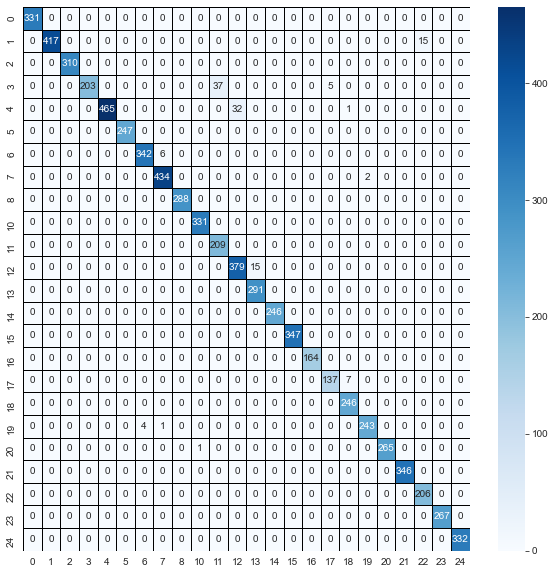

In [ ]:
cm = confusion_matrix(test_df_src["label"], predictions)
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

### Test with a clear image from outside the dataset
The image is of the letter "A" sign

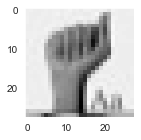

In [ ]:
image_a = cv.imread(IMAGE_A_PATH, cv.IMREAD_GRAYSCALE)
plt.figure(figsize = (2,2))
plt.imshow(image_a, cmap="gray")

The perdiction is indeed of the letter A

In [ ]:
a_reshaped = image_a.reshape(-1,28,28,1)/ 255
np.argmax(model.predict(a_reshaped), axis=-1)

array([0])

array([7])

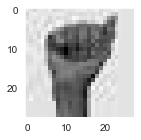

In [ ]:
img = cv.imread("../resources/a2.jpeg", cv.IMREAD_GRAYSCALE)
plt.figure(figsize = (2,2))
plt.imshow(img, cmap="gray")
reshaped = img.reshape(-1,28,28,1) / 255
np.argmax(model.predict(reshaped), axis=-1)

array([18])

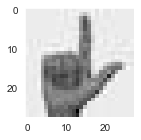

In [ ]:
img = cv.imread("../resources/l.jpeg", cv.IMREAD_GRAYSCALE)
plt.figure(figsize = (2,2))
plt.imshow(img, cmap="gray")
reshaped = img.reshape(-1,28,28,1)/ 255
np.argmax(model.predict(reshaped), axis=-1)

array([15])

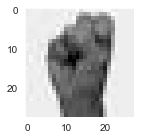

In [ ]:
img = cv.imread("../resources/s.jpeg", cv.IMREAD_GRAYSCALE)
plt.figure(figsize = (2,2))
plt.imshow(img, cmap="gray")
reshaped = img.reshape(-1,28,28,1)/ 255
np.argmax(model.predict(reshaped), axis=-1)